<a href="https://colab.research.google.com/github/ArmandDS/toxic_detection/blob/master/toxic_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Load the libraries

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from zipfile import ZipFile
import re
from nltk.stem.snowball import SnowballStemmer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
import nltk
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import stopwords
import string
from sklearn.linear_model import SGDClassifier
import logging
from textblob import TextBlob
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import warnings;warnings.filterwarnings('ignore')

### Get the First Dataset

In [27]:
!wget https://raw.githubusercontent.com/t-davidson/hate-speech-and-offensive-language/master/data/labeled_data.csv

--2019-08-19 15:31:47--  https://raw.githubusercontent.com/t-davidson/hate-speech-and-offensive-language/master/data/labeled_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2546446 (2.4M) [text/plain]
Saving to: ‘labeled_data.csv.1’

labeled_data.csv.1  100%[===================>]   2.43M  --.-KB/s    in 0.1s    

2019-08-19 15:31:47 (24.0 MB/s) - ‘labeled_data.csv.1’ saved [2546446/2546446]



In [29]:
df_corpus = pd.read_csv("labeled_data.csv")
df_corpus.shape

(24783, 7)

In [30]:
df_corpus.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [31]:
df_corpus['class'].value_counts()

1    19190
2     4163
0     1430
Name: class, dtype: int64

In [32]:
df_corpus.drop_duplicates(inplace=True)
df_corpus.shape

(24783, 7)

In [0]:
df_corpus['class'] = df_corpus['class'].apply(lambda x: 1 if (x==0  or x==1) else 0)

### The Class Distribution

Text(0.5, 1.0, 'Count of Toxic Comment of Dataset 1')

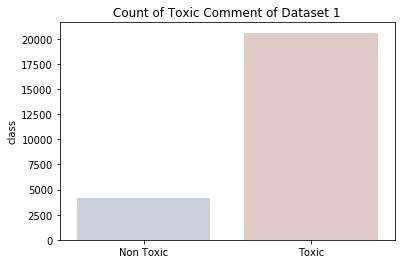

In [40]:
sns.barplot(['Non Toxic', 'Toxic'], df_corpus['class'].map({0:"Non Toxic", 1: "Toxic"}).value_counts(ascending=True), alpha=0.8,palette="vlag")

plt.title('Count of Toxic Comment of Dataset 1')



### Get the Second Dataset

In [33]:
!wget https://raw.githubusercontent.com/prateekjoshi565/twitter_sentiment_analysis/master/train_E6oV3lV.csv

--2019-08-19 15:31:55--  https://raw.githubusercontent.com/prateekjoshi565/twitter_sentiment_analysis/master/train_E6oV3lV.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3103165 (3.0M) [text/plain]
Saving to: ‘train_E6oV3lV.csv.1’

train_E6oV3lV.csv.1 100%[===================>]   2.96M  --.-KB/s    in 0.1s    

2019-08-19 15:31:55 (29.3 MB/s) - ‘train_E6oV3lV.csv.1’ saved [3103165/3103165]



In [34]:
df_corpus2 = pd.read_csv("train_E6oV3lV.csv", error_bad_lines=False)
df_corpus2.shape

(31962, 3)

In [35]:
df_corpus2.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [0]:
df_corpus2.columns = ["id", "class", "tweet"]

### The Class Distribution

Text(0.5, 1.0, 'Count of Toxic Comment of Dataset 2')

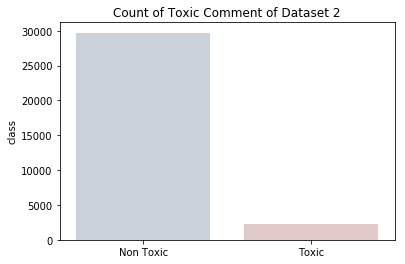

In [37]:
sns.barplot(['Non Toxic', 'Toxic'], df_corpus2['class'].map({0:"Non Toxic", 1: "Toxic"}).value_counts(), alpha=0.8,palette="vlag")


plt.title('Count of Toxic Comment of Dataset 2')


### Merge the Dataset

In [0]:
df_corpus_final = pd.concat([df_corpus[['class', 'tweet']], df_corpus2[['class', 'tweet']]])

In [42]:
df_corpus_final.head()

,class,tweet
0,0,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [0]:
df_corpus_final.reset_index( drop=True, inplace=True)

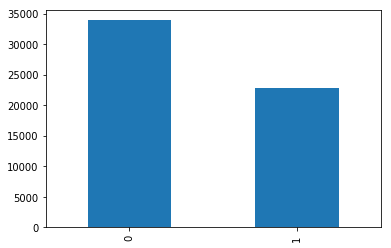

In [44]:
df_corpus_final['class'].value_counts().plot(kind='bar')

### The Distribution for the merged Dataset

Text(0.5, 1.0, 'Count of Toxic Comment All Datasets ')

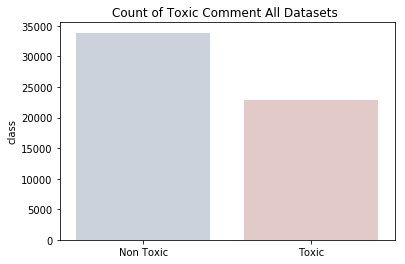

In [45]:
sns.barplot(['Non Toxic', 'Toxic'], df_corpus_final['class'].map({0:"Non Toxic", 1: "Toxic"}).value_counts(), alpha=0.8,palette="vlag")
plt.title('Count of Toxic Comment All Datasets ')


## Functions for cleaning the data

In [46]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [0]:
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase


In [0]:
stop_words_ = set(stopwords.words('english'))
wn = WordNetLemmatizer()

my_sw = ['rt', 'ht', 'fb', 'amp', 'gt']
def black_txt(token):
  if token == 'u':
    token = 'you'
  return  token not in stop_words_ and token not in list(string.punctuation) and token not in my_sw

def cleaner(word):
  #Remove links
  word = re.sub(r'((http|https)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+\.([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-_=#])*', 
                '', word, flags=re.MULTILINE)
  #Decontracted words
  word = decontracted(word)
  #Remove users mentions
  word = re.sub(r'(@[^\s]*)', "", word)
  word = re.sub('[\W]', ' ', word)
  #Lemmatized
  list_word_clean = []
  for w1 in word.split(" "):
    if  black_txt(w1.lower()):
      word_lemma =  wn.lemmatize(w1,  pos="v")
      list_word_clean.append(word_lemma)

  #Cleaning, lowering and remove whitespaces
  word = " ".join(list_word_clean)
  word = re.sub('[^a-zA-Z]', ' ', word)
  return word.lower().strip()

In [49]:
 df_corpus.iloc[24579]['tweet']

'this is why i love birds. http://t.co/Gk2wiNhBkw'

In [50]:
cleaner(df_corpus.iloc[24579]['tweet'])

'love bird'

### Testing the cleaner functions

In [51]:
for idx in df_corpus.tail(15).index:
  print(cleaner(df_corpus.iloc[idx]['tweet']),'\n'  , df_corpus.iloc[idx]['tweet'], idx)
  print("************")

know favorite tweet  tryna cheat ass bitch haha 
 you know what your doing when you favorite a tweet, tryna cheat ass bitch haha 24768
************
lil dumb ass bitch  ai fuckin wit chu    get million  trillion things would rather fuckin    fuckin witchu 
 you lil dumb ass bitch, i ain't fuckin wit chu!.. i got a million, trillion things i'd rather fuckin' do.. than to be fuckin witchu. 24769
************
look like ac  call anymore 
 you look like AC Green...bitch don't call here anymore... 24770
************
look like    stop talk fuck bitch 
 you look like your 12 stop talking about fucking bitches &#9757; 24771
************
might well go pussy pop stage 
 you might as well gone pussy pop on a stage 24772
************
niggers cheat ya gf  smh 
 you niggers cheat on ya gf's? smh.... 24773
************
really care bout dis bitch  dick yo feel 
 you really care bout dis bitch. my dick all in yo feelings 24774
************
worry bout bitch  need 
 you worried bout other bitches, you need

## Build The Model


In [52]:
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM, Embedding
from sklearn.preprocessing import LabelBinarizer
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.utils import np_utils
from keras.layers import Dense, Input, LSTM, Bidirectional, Activation, Conv1D, GRU, TimeDistributed
from keras.layers import Dropout, Embedding, GlobalMaxPooling1D, MaxPooling1D, Add, Flatten, SpatialDropout1D
from keras.layers import GlobalAveragePooling1D, BatchNormalization, concatenate
from keras.layers import Reshape, merge, Concatenate, Lambda, Average
from keras import backend as K
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints
from keras.models import Model

Using TensorFlow backend.


In [0]:
X = df_corpus_final['tweet']
y = df_corpus_final['class']
encoder = LabelEncoder()
y = encoder.fit_transform(y)
Y = np_utils.to_categorical(y)


In [0]:
from sklearn.base import BaseEstimator, TransformerMixin

In [55]:
import spacy
!python -m spacy download en_core_web_lg

     |████████████████████████████████| 826.9MB 1.2MB/s 
  Created wheel for en-core-web-lg: filename=en_core_web_lg-2.1.0-cp36-none-any.whl size=828255076 sha256=4b88e8010b5e26ba9db543276eba8b34bcd36e602454f7fd64072a6f7a0c33ca
  Stored in directory: /tmp/pip-ephem-wheel-cache-n8sauskf/wheels/b4/d7/70/426d313a459f82ed5e06cc36a50e2bb2f0ec5cb31d8e0bdf09
Successfully built en-core-web-lg
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [0]:
nlp = spacy.load('/usr/local/lib/python3.6/dist-packages/en_core_web_lg/en_core_web_lg-2.1.0')

#### Build the embedding

In [0]:
tokenizer = Tokenizer(num_words=30000)
tokenizer.fit_on_texts(df_corpus_final['tweet'])
embeddings_index = np.zeros((30000 + 1, 300))
for word, idx in tokenizer.word_index.items():
    try:
          embedding = nlp.vocab[word].vector
          embeddings_index[idx] = embedding
    except:
      pass

In [58]:
embeddings_index[1]

array([ 1.60820007e-01,  1.10079996e-01, -2.81289995e-01,  9.64860022e-02,
       -3.53289992e-01,  4.40560013e-01, -1.58779994e-01, -7.74060011e-01,
        2.15609998e-01,  9.46659982e-01, -5.03459983e-02,  3.00689995e-01,
       -7.45180011e-01, -6.62230030e-02,  2.21289992e-02, -1.57869995e-01,
       -4.68109995e-01,  2.65910006e+00, -5.90980016e-02, -1.44270003e-01,
       -2.34070003e-01,  1.61709994e-01, -2.59339988e-01, -3.55630010e-01,
        4.59410012e-01,  1.56340003e-01,  2.69609988e-01, -4.73089993e-01,
        2.23560005e-01,  1.08489998e-01, -3.55049998e-01, -1.82129994e-01,
       -7.31550008e-02, -1.94690004e-01, -5.19100010e-01, -1.15690000e-01,
        6.86910003e-02,  4.85190004e-02, -2.94649992e-02, -3.76690000e-01,
        5.69030009e-02, -8.70790035e-02, -1.64299995e-01,  3.64060014e-01,
       -7.45580018e-01,  6.53109998e-02, -9.78090018e-02,  3.34580004e-01,
       -1.99510008e-02,  2.20159993e-01, -1.29539996e-01, -3.71450007e-01,
       -5.72849996e-02, -

### Building the estimator class

In [0]:
class KerasTextClassifier(BaseEstimator, TransformerMixin):
  '''Wrapper class for keras text classification models that takes raw text as input.'''
  
  def __init__(self, max_words=30000, input_length=20, emb_dim=300, n_classes=2, epochs=15, batch_size=64, emb_idx=0):
    self.max_words = max_words
    self.input_length = input_length
    self.emb_dim = emb_dim
    self.n_classes = n_classes
    self.epochs = epochs
    self.bs = batch_size
    self.embeddings_index = emb_idx
    self.tokenizer = Tokenizer(num_words=self.max_words+1, lower=True, split=' ')
    self.model = self._get_model()
    return self.model.summary()
    
  def _get_model(self):
    input_text = Input((self.input_length,))
    text_embedding = Embedding(input_dim=self.max_words+1, output_dim=self.emb_dim, input_length=self.input_length, 
                               mask_zero=False, weights=[self.embeddings_index], trainable=False)(input_text)
    text_embedding = SpatialDropout1D(0.4)(text_embedding)
    bilstm =(LSTM(units=50,  recurrent_dropout=0.2, return_sequences = True))(text_embedding)
    x = Dropout(0.2)(bilstm)
    x =(LSTM(units=50,  recurrent_dropout=0.2, return_sequences = True))(x)
    x = Dropout(0.2)(x)
    x =(LSTM(units=50,  recurrent_dropout=0.2))(x)
    out = Dense(units=self.n_classes, activation="softmax")(x)
    model = Model(inputs=[input_text],outputs=[out])
    model.compile(optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"])
    return model
  
  def _get_sequences(self, texts):
    seqs = self.tokenizer.texts_to_sequences(texts)
    return pad_sequences(seqs, maxlen=self.input_length, value=0)
  
  def _preprocess(self, texts):
    return [cleaner(x) for x in texts]
  
  def fit(self, X, y):
    '''Fit the vocabulary and the model.
       :params: X: list of texts. y: labels.
    '''
    self.tokenizer.fit_on_texts(X)
    self.tokenizer.word_index = {e: i for e,i in self.tokenizer.word_index.items() if i <= self.max_words}
    self.tokenizer.word_index[self.tokenizer.oov_token] = self.max_words + 1
    seqs = self._get_sequences(self._preprocess(X))
    self.model.fit([seqs ], y, batch_size=self.bs, epochs=self.epochs, validation_split=0.1)
  
  def predict_proba(self, X, y=None):
    seqs = self._get_sequences(self._preprocess(X))
    return self.model.predict(seqs)
  
  def predict(self, X, y=None):
    return np.argmax(self.predict_proba(X), axis=1)
  
  def score(self, X, y):
    y_pred = self.predict(X)
    return accuracy_score(np.argmax(y, axis=1), y_pred)

In [60]:
text_model = KerasTextClassifier(emb_idx= embeddings_index)

W0819 15:35:28.525487 139649561126784 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0819 15:35:28.586541 139649561126784 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0819 15:35:28.604639 139649561126784 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0819 15:35:28.623487 139649561126784 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0819 15:35:28.624661 1396495611

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 20)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 20, 300)           9000300   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 20, 300)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 20, 50)            70200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 20, 50)            20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 20, 50)            0         
__________

In [0]:
x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size = 0.1, random_state = 40, stratify=Y)

#### Train  the model

In [62]:
text_model.fit(x_train, y_train)

W0819 15:35:51.941365 139649561126784 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 45963 samples, validate on 5107 samples
Epoch 1/15
45963/45963 [==============================] - 107s 2ms/step - loss: 0.3424 - acc: 0.8606 - val_loss: 0.2413 - val_acc: 0.9144
Epoch 2/15
45963/45963 [==============================] - 103s 2ms/step - loss: 0.2487 - acc: 0.9105 - val_loss: 0.2051 - val_acc: 0.9270
Epoch 3/15
45963/45963 [==============================] - 103s 2ms/step - loss: 0.2192 - acc: 0.9222 - val_loss: 0.1966 - val_acc: 0.9344
Epoch 4/15
45963/45963 [==============================] - 105s 2ms/step - loss: 0.2031 - acc: 0.9283 - val_loss: 0.1811 - val_acc: 0.9375
Epoch 5/15
45963/45963 [==============================] - 105s 2ms/step - loss: 0.1917 - acc: 0.9311 - val_loss: 0.1819 - val_acc: 0.9379
Epoch 6/15
45963/45963 [==============================] - 105s 2ms/step - loss: 0.1826 - acc: 0.9342 - val_loss: 0.1737 - val_acc: 0.9409
Epoch 7/15
45963/45963 [==============================] - 105s 2ms/step - loss: 0.1757 - acc: 0.9364 - val_loss: 0.1718 - v

#### Evaluate the model

In [63]:
text_model.score(x_test, y_test)

0.9416740088105727

## Explaning with ELI5

In [0]:
from IPython.display import display, HTML

In [65]:
!pip install eli5

     |████████████████████████████████| 102kB 3.8MB/s 


In [66]:
import eli5
from eli5.lime import TextExplainer

for idx in x_test.index[190:210]:
  te = TextExplainer(random_state=42)
  te.fit(cleaner(x_test[idx]), text_model.predict_proba, )
  print("Real Class:",  ["Non Toxic" if x == 0 else "Toxic" for x in [df_corpus_final.iloc[idx]['class']]])
  print("Text uncleaned tweet:", df_corpus_final.iloc[idx]['tweet'])
  print("ELI5 Predicted Class:")
  display(te.show_prediction(target_names=[ 'Non Toxic','Toxic',]))
 

Real Class: ['Toxic']
Text uncleaned tweet: tyler perry says backlash over his tlc show is 'reverse racism'  
ELI5 Predicted Class:


Real Class: ['Non Toxic']
Text uncleaned tweet: watch angry grandpa react to gift of new house  video:     #grandpa #house 
ELI5 Predicted Class:


Real Class: ['Toxic']
Text uncleaned tweet: @user has your body, the bodies of your generations, been the sites of fear, repulsion, violent desire,hatred? #ableismâ¦ 
ELI5 Predicted Class:


Real Class: ['Non Toxic']
Text uncleaned tweet: coffee &amp; beer l... gbp 16.00 get here:  #shop #cool   #home #fun 
ELI5 Predicted Class:


Real Class: ['Non Toxic']
Text uncleaned tweet: happy dog smiles #ursa  camper #adogsway  #dog #smile #lab #shepherd #rottweilerâ¦ 
ELI5 Predicted Class:


Real Class: ['Toxic']
Text uncleaned tweet: RT @SpacePlankton: If one more FB idiot bitches about the weather, I will hunt them down &amp; kill them with kindness because everyone is enti&#8230;
ELI5 Predicted Class:


Real Class: ['Toxic']
Text uncleaned tweet: "@_TommyCollins: @WeAreRichnow @buffalobills yeah Texans are so much better you fucking retard" I see that you're mad about this.
ELI5 Predicted Class:


Real Class: ['Non Toxic']
Text uncleaned tweet: gonna spend time with the kids an mom.w  well see how i sleep with out him there it maybe #weird   #emotional
ELI5 Predicted Class:


Real Class: ['Non Toxic']
Text uncleaned tweet: i am refined. #i_am #positive #affirmation     
ELI5 Predicted Class:


Real Class: ['Non Toxic']
Text uncleaned tweet: #waterbury   attack bull chase: when you leave the lot despite the fact that you're a strong source of f 
ELI5 Predicted Class:


Real Class: ['Non Toxic']
Text uncleaned tweet: sunglasses are currently at the bottom of a lake  
ELI5 Predicted Class:


Real Class: ['Toxic']
Text uncleaned tweet: RT @HilariousBubble: Texting bitches at 11:12, making their wish come true.
ELI5 Predicted Class:


Real Class: ['Toxic']
Text uncleaned tweet: SOO guys those tweets are bullshit. Be you.. And if the bitch "is to stupid what she wants" then she not stupid It's that she doesn't want u
ELI5 Predicted Class:


Real Class: ['Toxic']
Text uncleaned tweet: I'm always dumb too a extra slow ass bitch &#128574;&#128530;&#128514;&#128584;&#128553;&#128175;&#128074;
ELI5 Predicted Class:


Real Class: ['Non Toxic']
Text uncleaned tweet:  @user we know you want your #staff to be  ....show appreciation with a #coffee #day #nohcarolina where?
ELI5 Predicted Class:


Real Class: ['Non Toxic']
Text uncleaned tweet: The republican teabaggers hate this but screw em. http://t.co/6iutHYvhQm
ELI5 Predicted Class:


Real Class: ['Non Toxic']
Text uncleaned tweet: wonder if matt was angry or high when he composed this..  ...#muse #awesome #fuckingmotherfucker   #motherfucker
ELI5 Predicted Class:


Real Class: ['Toxic']
Text uncleaned tweet: Yo bitch go wild more miles on her pussy then my car do
ELI5 Predicted Class:


Real Class: ['Toxic']
Text uncleaned tweet: @KingsleeyNYC yep lmao. Its been a hectic few weeks. Waddup ho
ELI5 Predicted Class:


Real Class: ['Non Toxic']
Text uncleaned tweet: 50 people now confirmed dead. wow   #orlandoshooting
ELI5 Predicted Class:
